In [1]:
pip install opencv-python numpy

In [2]:
!pip install kagglehub

In [3]:
!nvidia-smi

Fri Apr 18 12:34:07 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   30C    P0             48W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [4]:
from google.colab import files
files.upload()  # upload kaggle.json

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [5]:
!pip install -q kaggle

# Make sure your kaggle.json is already uploaded and in place
!kaggle datasets download -d octopusteam/full-imdb-dataset --unzip

Dataset URL: https://www.kaggle.com/datasets/octopusteam/full-imdb-dataset
License(s): CC0-1.0


In [6]:
!ls

data.csv  kaggle.json  sample_data


In [7]:
import os

os.listdir('.')

['.config', 'kaggle.json', 'data.csv', 'sample_data']

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.metrics import accuracy_score, confusion_matrix
import cudf
import cuml
from cuml.linear_model import LogisticRegression
from cuml.model_selection import train_test_split
from cuml.preprocessing import StandardScaler

In [9]:
df = cudf.read_csv('data.csv')
df.head()

,id,title,type,genres,averageRating,numVotes,releaseYear
0,tt0000009,Miss Jerry,movie,Romance,5.4,223,1894
1,tt0000147,The Corbett-Fitzsimmons Fight,movie,"Documentary, News, Sport",5.3,557,1897
2,tt0000502,Bohemios,movie,<NA>,3.8,22,1905
3,tt0000574,The Story of the Kelly Gang,movie,"Action, Adventure, Biography",6.0,983,1906
4,tt0000591,The Prodigal Son,movie,Drama,5.7,32,1907


# Basic EDA with cuDF

In [10]:
# Shape of the dataset
print("Rows:", df.shape[0])
print("Columns:", df.shape[1])

# Data types
print(df.dtypes)

# Check for nulls
print(df.isnull().sum())

# Describe numerical features
df.describe()

Rows: 1056870
Columns: 7
id                object
title             object
type              object
genres            object
averageRating    float64
numVotes           int64
releaseYear        int64
dtype: object
id                    0
title                 0
type                  0
genres           102770
averageRating    601288
numVotes         601288
releaseYear      134161
dtype: int64


,averageRating,numVotes,releaseYear
count,455582.000000,4.555820e+05,922709.000000
mean,6.351876,3.028763e+03,1998.720314
std,1.425650,3.281934e+04,27.002609
min,1.000000,5.000000e+00,1888.000000
25%,5.500000,1.700000e+01,1987.000000
50%,6.500000,5.100000e+01,2010.000000
75%,7.300000,2.580000e+02,2018.000000
max,10.000000,3.033388e+06,2031.000000


In [11]:
# Convert cuDF dataframe to pandas for string manipulation
df_pandas = df.to_pandas()

# Define the function to count genres
def count_genres(genre_str):
    return len(genre_str.split(',')) if genre_str else 0

# Apply the function to count genres
df_pandas['numGenres'] = df_pandas['genres'].apply(count_genres)

# Convert back to cuDF
df['numGenres'] = cudf.Series(df_pandas['numGenres'])

# Check the new feature
df['numGenres'].describe()

count    1.056870e+06
mean     1.339028e+00
std      8.278430e-01
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      3.000000e+00
Name: numGenres, dtype: float64

In [12]:
# Drop rows with null values in any of the relevant columns
df = df.dropna(subset=['averageRating', 'numVotes', 'releaseYear'])

# Convert columns to CuPy arrays again
num_genres = df['numGenres'].values
avg_rating = df['averageRating'].values
num_votes = df['numVotes'].values
release_year = df['releaseYear'].values

In [13]:
# Create a new feature: decade
df['decade'] = (df['releaseYear'] // 10) * 10
df['decade'] = df['decade'].astype('int32')

# Check the new feature
df['decade'].value_counts()

decade
2010    141100
2020     81865
2000     71812
1990     38528
1980     33018
1970     27616
1960     20090
1950     14436
1930      9543
1940      9419
1920      4790
1910      3075
1900       124
1890        12
1880         1
Name: count, dtype: int64

**Distribution of Genres Using cuDF**

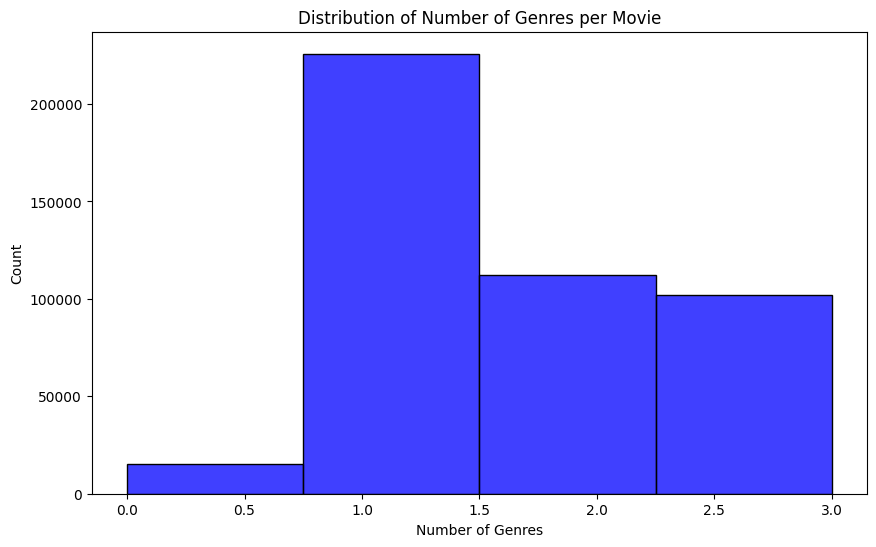

In [14]:
import cudf
import cupy as cp
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the cuDF DataFrame 'numGenres' to a CuPy array for GPU-accelerated plotting
num_genres = df['numGenres'].values  # This gives a CuPy ndarray directly

# Plot the distribution of the 'numGenres' column (GPU accelerated with CuPy)
plt.figure(figsize=(10, 6))
sns.histplot(cp.asnumpy(num_genres), bins=4, kde=False, color='blue')  # Convert to NumPy for plotting
plt.title('Distribution of Number of Genres per Movie')
plt.xlabel('Number of Genres')
plt.ylabel('Count')
plt.show()

**Correlation Analysis Using cuML**

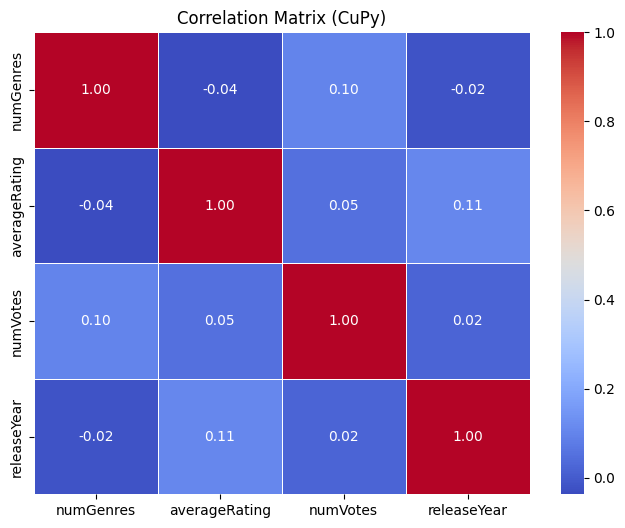

In [15]:
import cupy as cp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Stack the data into a CuPy matrix
data_matrix = cp.vstack([num_genres, avg_rating, num_votes, release_year]).T

# Compute the correlation matrix using CuPy
corr_matrix = cp.corrcoef(data_matrix, rowvar=False)

# Convert the result to a pandas DataFrame for plotting
corr_df = pd.DataFrame(cp.asnumpy(corr_matrix),
                       columns=['numGenres', 'averageRating', 'numVotes', 'releaseYear'],
                       index=['numGenres', 'averageRating', 'numVotes', 'releaseYear'])

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix (CuPy)')
plt.show()


**Top Genres by Frequency**

<ipython-input-16-8e04075cd08d>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=genre_df.head(15), x='Genre', y='Count', palette='viridis')


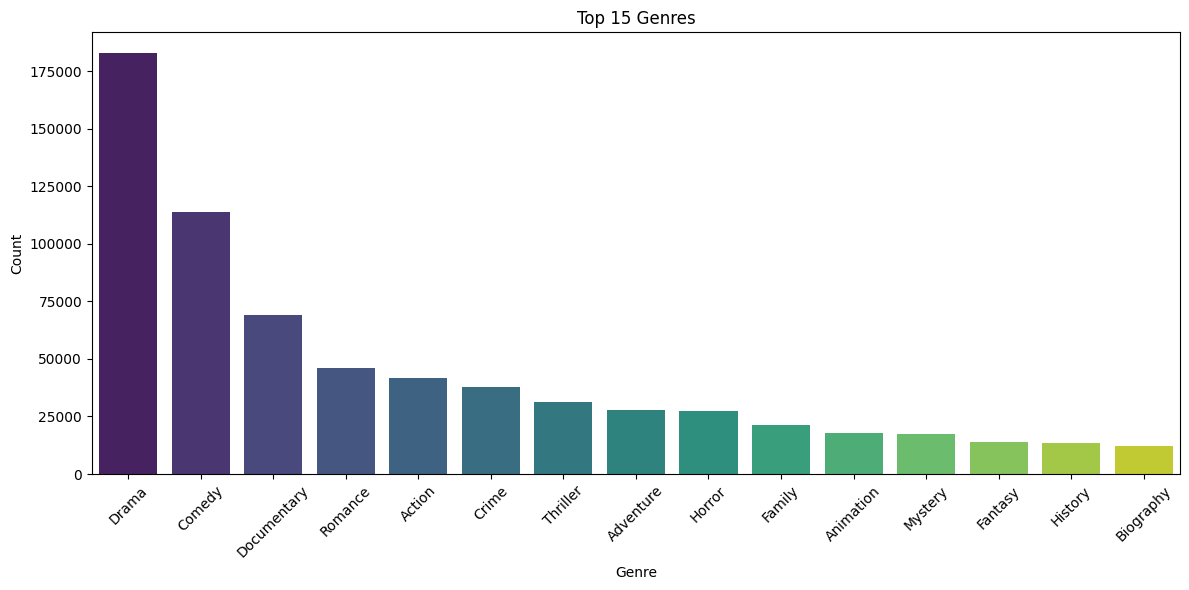

In [16]:
# First, convert the cuDF Series to a regular list of strings
genres_list = df['genres'].to_pandas().dropna().str.split(',')

# Flatten the list of genre lists and count each genre
from collections import Counter
flat_genres = [genre.strip() for sublist in genres_list for genre in sublist]
genre_counts = Counter(flat_genres)

# Convert to DataFrame and plot
genre_df = pd.DataFrame(genre_counts.items(), columns=['Genre', 'Count']).sort_values(by='Count', ascending=False)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=genre_df.head(15), x='Genre', y='Count', palette='viridis')
plt.title('Top 15 Genres')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Trend of Movie Releases Over Time**

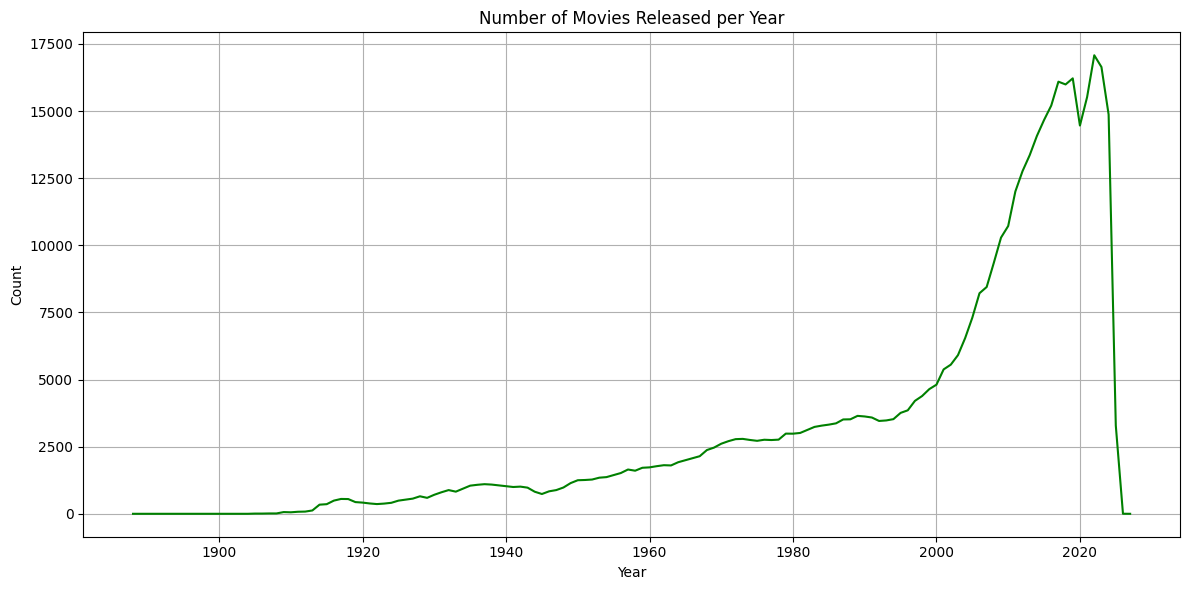

In [17]:
# Convert to pandas for easier year aggregation
year_df = df[['releaseYear']].to_pandas().dropna()
year_counts = year_df['releaseYear'].value_counts().sort_index()

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(x=year_counts.index, y=year_counts.values, color='green')
plt.title('Number of Movies Released per Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.grid(True)
plt.tight_layout()
plt.show()

**Use cuML for Regression**

In [18]:
from cuml.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Prepare the DataFrame (make sure all features are numeric and clean)
X = df[['numGenres', 'numVotes', 'releaseYear']].dropna()
y = df['averageRating'].loc[X.index]

# Split the data (use pandas since cuml accepts pandas or cudf)
X_train, X_test, y_train, y_test = train_test_split(X.to_pandas(), y.to_pandas(), test_size=0.2, random_state=42)


In [19]:
# Convert to cuDF for cuML
X_train_cudf = cudf.DataFrame.from_pandas(X_train)
X_test_cudf = cudf.DataFrame.from_pandas(X_test)
y_train_cudf = cudf.Series(y_train)
y_test_cudf = cudf.Series(y_test)

# Train
model = LinearRegression()
model.fit(X_train_cudf, y_train_cudf)

# Predict and evaluate
y_pred = model.predict(X_test_cudf)

from cuml.metrics import r2_score
r2 = r2_score(y_test_cudf, y_pred)
print(f"R² score (GPU): {r2:.4f}")

R² score (GPU): 0.0141


In [20]:
import numpy as np
df['logVotes'] = cudf.Series(np.log1p(df['numVotes'].to_pandas()))

In [21]:
df['type_encoded'] = df['type'].astype('category').cat.codes

In [22]:
top_genres = ['Action', 'Drama', 'Comedy', 'Thriller', 'Romance']
for genre in top_genres:
    df[f'genre_{genre}'] = df['genres'].str.contains(genre).fillna(False).astype('int8')


In [23]:
features = ['numGenres', 'logVotes', 'releaseYear', 'type_encoded'] + [f'genre_{g}' for g in top_genres]
X = df[features].dropna()
y = df['averageRating'].loc[X.index]

# Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X.to_pandas(), y.to_pandas(), test_size=0.2, random_state=42)

# Convert back to cuDF
X_train_cudf = cudf.DataFrame.from_pandas(X_train)
X_test_cudf = cudf.DataFrame.from_pandas(X_test)
y_train_cudf = cudf.Series(y_train)
y_test_cudf = cudf.Series(y_test)

# Train
from cuml.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train_cudf, y_train_cudf)

# Predict & Score
y_pred = model.predict(X_test_cudf)
from cuml.metrics import r2_score
r2 = r2_score(y_test_cudf, y_pred)
print(f"New R² score (GPU): {r2:.4f}")


New R² score (GPU): 0.0727


In [24]:
from cuml.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, max_depth=12)
rf.fit(X_train_cudf, y_train_cudf)
y_pred_rf = rf.predict(X_test_cudf)

r2_rf = r2_score(y_test_cudf, y_pred_rf)
print(f"Random Forest R² score (GPU): {r2_rf:.4f}")


Random Forest R² score (GPU): 0.1690


In [25]:
import cudf

# Split and explode genres
genres_split = df['genres'].str.split(',')
genres_exploded = genres_split.explode()

# Get top 10 most frequent genres
top_genres = genres_exploded.value_counts().head(10).index.to_pandas()

# Add binary columns for top genres
for genre in top_genres:
    df[f'genre_{genre}'] = df['genres'].str.contains(genre).fillna(False).astype('int8')

**Define Feature Set**

In [26]:
# Define feature columns
genre_cols = [f'genre_{g}' for g in top_genres]
feature_cols = ['numGenres', 'numVotes', 'releaseYear'] + genre_cols

# Extract features and target
X = df[feature_cols]
y = df['averageRating']

**Train/Test Split (80/20)**

In [27]:
from cuml.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

**Train Random Forest on GPU**

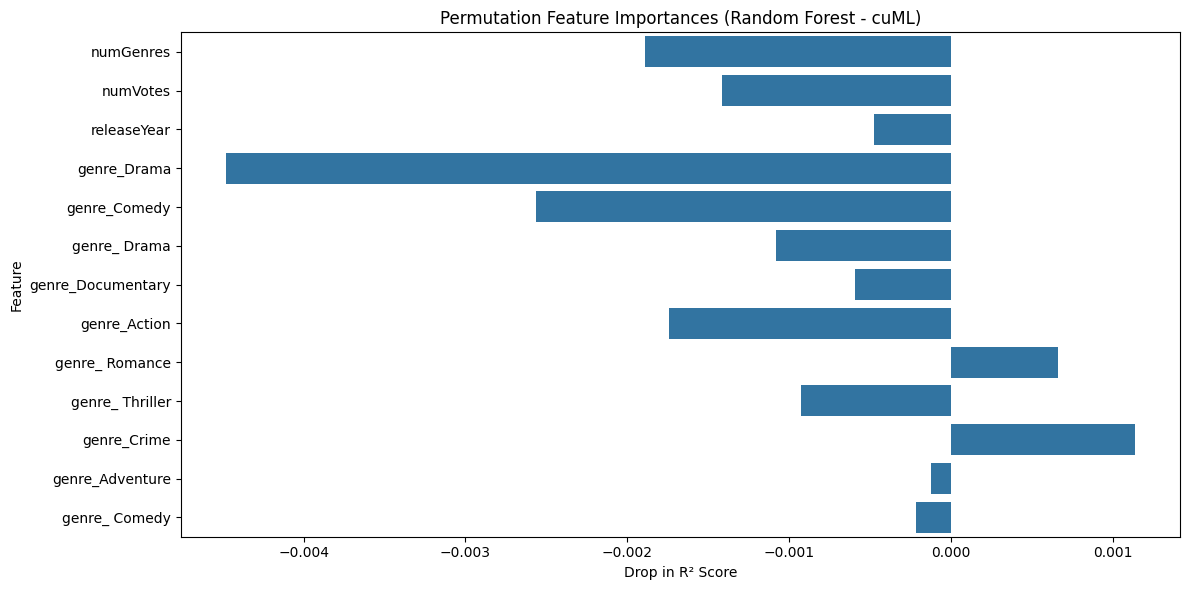

In [28]:
import cupy as cp
from sklearn.metrics import r2_score

def permutation_importance(model, X, y_cudf, metric=r2_score):
    # Ensure y is CuPy array
    y = y_cudf.to_cupy()
    base_score = metric(y.get(), model.predict(X).to_cupy().get())  # Convert to NumPy arrays
    importances = []

    for col in X.columns:
        X_permuted = X.copy(deep=True)
        X_permuted[col] = cp.random.permutation(X[col].to_cupy())
        score = metric(y.get(), model.predict(X_permuted).to_cupy().get())  # Convert to NumPy arrays
        importances.append(base_score - score)

    return cp.array(importances)

# Run permutation importance
importances = permutation_importance(rf, X_test, y_test)

# Convert to CPU for plotting
importances_cpu = importances.get()

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(x=importances_cpu, y=feature_cols)
plt.title('Permutation Feature Importances (Random Forest - cuML)')
plt.xlabel('Drop in R² Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

**Gradient Boosting Regressor**

In [29]:
import cupy as cp
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score  # Use sklearn's r2_score since we are converting to NumPy

# Convert cuDF DataFrame to CuPy arrays for GPU-accelerated computation
X_train_cp = X_train.to_cupy()
y_train_cp = y_train.to_cupy()
X_test_cp = X_test.to_cupy()
y_test_cp = y_test.to_cupy()  # Ensure y_test is also converted to CuPy

# Convert CuPy arrays to NumPy arrays for sklearn compatibility
X_train_np = X_train_cp.get()
y_train_np = y_train_cp.get()
X_test_np = X_test_cp.get()
y_test_np = y_test_cp.get()  # Ensure y_test is converted to NumPy

# Create the GradientBoostingRegressor model
gbr = GradientBoostingRegressor(n_estimators=100, max_depth=8)

# Fit the model on the training data
gbr.fit(X_train_np, y_train_np)

# Make predictions
y_pred_gbr = gbr.predict(X_test_np)

# Calculate R² score using sklearn's r2_score
r2_gbr = r2_score(y_test_np, y_pred_gbr)
print(f"Gradient Boosted R² score (GPU): {r2_gbr:.4f}")

Gradient Boosted R² score (GPU): 0.1673


In [43]:
from joblib import dump

dump(gbr, 'best_gbr_model.joblib')

['best_gbr_model.joblib']

In [44]:
from joblib import load

loaded_gbr = load('best_gbr_model.joblib')
y_pred_loaded = loaded_gbr.predict(X_test_np)

**GPU-accelerated Support Vector Machine Regressor (SVM)**

In [30]:
from cuml.svm import SVR as cumlSVR
from cuml.metrics import r2_score

# Convert cuDF DataFrame to CuPy arrays for GPU-accelerated computation
X_train_cp = X_train.astype('float32').to_cupy()  # Convert to float32
y_train_cp = y_train.astype('float32').to_cupy()  # Convert to float32
X_test_cp = X_test.astype('float32').to_cupy()    # Convert to float32

# Create the GPU-accelerated Support Vector Regressor (SVR) model
svr = cumlSVR(kernel='rbf', C=1.0, epsilon=0.1)

# Fit the model on the training data
svr.fit(X_train_cp, y_train_cp)

# Make predictions
y_pred_svr = svr.predict(X_test_cp)

# Calculate R² score using cuML's r2_score
r2_svr = r2_score(y_test_cp, y_pred_svr)
print(f" SVM Regressor R² score (GPU): {r2_svr:.4f}")

 SVM Regressor R² score (GPU): 0.0076


In [41]:
from joblib import dump
dump(svr, 'best_svr_model.joblib')

['best_svr_model.joblib']

In [42]:
from joblib import load
loaded_svr = load('best_svr_model.joblib')

**GPU-accelerated KMeans Clustering**

/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:193: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  ret = func(*args, **kwargs)


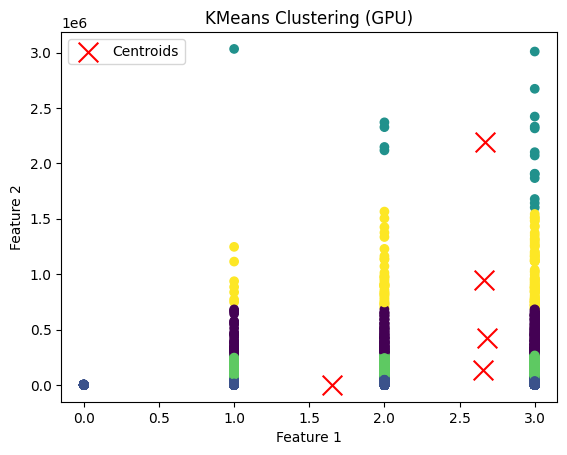

In [31]:
from cuml.cluster import KMeans as cumlKMeans
import matplotlib.pyplot as plt

# Convert cuDF DataFrame to CuPy arrays for GPU-accelerated computation
X_train_cp = X_train.to_cupy()

# Create the KMeans clustering model
kmeans = cumlKMeans(n_clusters=5, random_state=42)

# Fit the model on the training data
kmeans.fit(X_train_cp)

# Predict the cluster centers
cluster_centers = kmeans.cluster_centers_

# Predict the clusters for each data point
labels = kmeans.predict(X_train_cp)

# Plot the clusters (2D example)
plt.scatter(X_train_cp[:, 0].get(), X_train_cp[:, 1].get(), c=labels.get(), cmap='viridis')
plt.scatter(cluster_centers[:, 0].get(), cluster_centers[:, 1].get(), marker='x', color='red', s=200, label='Centroids')
plt.title('KMeans Clustering (GPU)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

In [32]:
import cupy as cp
from cuml.svm import SVR as cumlSVR
from cuml.ensemble import RandomForestRegressor as cumlRF
from cuml.metrics import r2_score
import xgboost as xgb
from sklearn.model_selection import train_test_split
import cudf

# Assuming the dataset `df` is already loaded and preprocessed
# For example, if 'target' is your target column and others are features
X = df.drop(columns='averageRating')  # Replace 'target' with your actual target column name
y = df['averageRating']  # Replace 'target' with your actual target column name

In [33]:
# Ensure categorical columns in both training and testing sets are one-hot encoded
categorical_columns = ['type', 'genres']  # Specify your categorical columns here

In [34]:
# Apply one-hot encoding to both training and testing sets
X_encoded = cudf.get_dummies(X, columns=categorical_columns, drop_first=True)

In [35]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)


In [36]:
# Now ensure both training and testing sets are of numeric type
X_train_encoded = X_train.select_dtypes(include=['float32', 'float64'])
X_test_encoded = X_test.select_dtypes(include=['float32', 'float64'])

In [37]:
# Convert to CuPy arrays for GPU processing
X_train_cp = X_train_encoded.astype('float32').to_cupy()
y_train_cp = y_train.astype('float32').to_cupy()
X_test_cp = X_test_encoded.astype('float32').to_cupy()
y_test_cp = y_test.astype('float32').to_cupy()

**XGBoost**

In [38]:
# XGBoost (GPU)
dtrain = xgb.DMatrix(X_train_cp, label=y_train_cp)
dtest = xgb.DMatrix(X_test_cp, label=y_test_cp)

params = {
    'objective': 'reg:squarederror',
    'tree_method': 'hist',
    'device': 'cuda',
    'eval_metric': 'rmse'
}
xgb_model = xgb.train(params, dtrain, num_boost_round=100)
y_pred_xgb = xgb_model.predict(dtest)
r2_xgb = r2_score(y_test_cp, y_pred_xgb)
print(f"🌟 XGBoost R² score (GPU): {r2_xgb:.4f}")

🌟 XGBoost R² score (GPU): 0.0337


In [39]:
from joblib import dump
dump(xgb_model, 'best_model_xgb.joblib')

['best_model_xgb.joblib']

In [40]:
from joblib import load
loaded_model = load('best_model_xgb.joblib')

In [45]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from joblib import dump

# Convert to NumPy arrays for scikit-learn compatibility
X_train_np = X_train_cp.get()
y_train_np = y_train_cp.get()
X_test_np = X_test_cp.get()
y_test_np = y_test_cp.get()

# Define the model
xgb_reg = XGBRegressor(
    objective='reg:squarederror',
    tree_method='hist',  # Use 'gpu_hist' if you're sure GPU is available
    predictor='gpu_predictor',
    device='cuda'
)

# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Grid search with 3-fold cross-validation
grid = GridSearchCV(xgb_reg, param_grid, scoring='r2', cv=3, verbose=1, n_jobs=-1)
grid.fit(X_train_np, y_train_np)

# Best model and score
print("✅ Best parameters:", grid.best_params_)
print(f"✅ Best CV R²: {grid.best_score_:.4f}")

# Evaluate on test set
best_model = grid.best_estimator_
y_pred_best = best_model.predict(X_test_np)
r2_best = r2_score(y_test_np, y_pred_best)
print(f"🌟 XGBoost Best R² score (on test set): {r2_best:.4f}")

# Save the best model
dump(best_model, 'best_xgb_model_gridsearch.joblib')


Fitting 3 folds for each of 72 candidates, totalling 216 fits
✅ Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'subsample': 1.0}
✅ Best CV R²: 0.0322
🌟 XGBoost Best R² score (on test set): 0.0339


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:49:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:49:05] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


['best_xgb_model_gridsearch.joblib']

In [46]:
import xgboost as xgb

# Convert NumPy to DMatrix for proper GPU prediction
dtest_gpu = xgb.DMatrix(X_test_np, missing=np.nan)

# Predict using booster directly
booster = best_model.get_booster()  # from sklearn XGBRegressor
y_pred_dmatrix = booster.predict(dtest_gpu)